In [1]:
import numpyro
numpyro.enable_x64()
# numpyro.set_platform('gpu')

import jax
print(jax.devices())

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value, init_to_sample, Trace_ELBO, TraceGraph_ELBO

from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam

import tensorflow_probability.substrates.jax as tfp

from jax import numpy as jnp
from jax import random, vmap

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from matplotlib import pyplot as plt

import pickle

from lib.helpers import *
from lib.models import *

[GpuDevice(id=0, process_index=0)]


In [2]:
## Define functions

def fit_svi(model, x_data, y_data, optimizer=Adam(1e-3), loss=TraceGraph_ELBO(), n_steps=10_000, full_rank = False, filename=None, **kwargs):
    if full_rank:
        guide = AutoMultivariateNormal(model, **kwargs)
    else:
        guide = AutoNormal(model, **kwargs)

    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    else:
        svi = SVI(model, guide, optimizer, loss)
        result = svi.run(random.PRNGKey(1), n_steps, x_data, y_data)
        output = {"params": result.params, "guide": guide, "losses": result.losses}

        if filename is not None:
            pickle.dump(output, open(filename, "wb"))

        return(output)


def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000, filename=None):
    
    if filename is not None and os.path.exists(filename):
#         result = pickle.load(open(filename, "rb")) ## replace with from_netcdf()
        result = az.from_netcdf(filename)
        return result
    
    else:
        
        posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
        samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
        samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(2), *args)

        ll_dict = numpyro.infer.util.log_likelihood(model, posterior_samples, *args, obs_data)
        data = {}
        for obs_name, log_like in ll_dict.items(): # don't think this is necessary but just to be safe ...
            shape = (1, len(log_like)) + log_like.shape[1:]
            data[obs_name] = np.reshape(log_like.copy(), shape)

        result = az.from_dict(
            {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
            prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
            posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
            log_likelihood = data,
            observed_data = {"yhat": obs_data}
        )
        
        if filename is not None:
#             pickle.dump(result, open(filename, "wb")) ## replace with to_netcdf()
            az.to_netcdf(result, filename)
        
        return(result)
        

In [3]:
## Load Experiment 1 data
df1 = load_data_exp1() 
df1 = df1[~df1.querytype.str.contains('or')] # filtering as in avg analyses

prop_divisible_by_5 = 1-np.sum((df1.estimate*100 % 5) != 0)/len(df1.estimate)

df1 = (df1 >>
    s.arrange(_.ID) >>
    s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
)

X_exp1, y_exp1 = make_model_data(df1)
print (prop_divisible_by_5, "% divsible by 5")
print(len(y_exp1), "observations")


0.9299081920903954 % divsible by 5
5664 observations


<AxesSubplot:xlabel='estimate'>

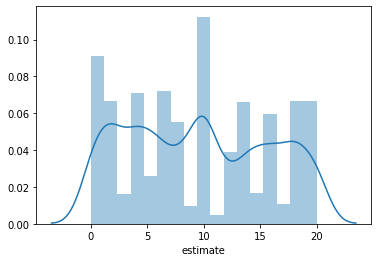

In [4]:
sns.distplot(df1.estimate)

In [5]:
## Load Experiment 2 data
df2 = load_data_exp2_trials()
prop_divisible_by_5 = 1-np.sum((df2.estimate*100 % 5) != 0)/len(df2.estimate)

df2 = (df2  >> 
        s.filter(_.condition!=2) >>
      s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
     )

X_exp2, y_exp2 = make_model_data(df2)

print (prop_divisible_by_5, "% divsible by 5")
print(len(y_exp2), "observations")

0.8868386243386244 % divsible by 5
10080 observations


<AxesSubplot:xlabel='estimate'>

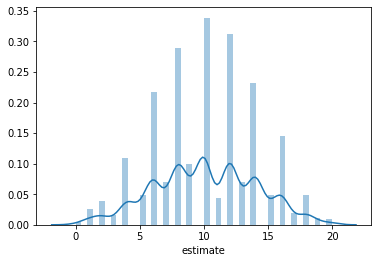

In [6]:
sns.distplot(df2.estimate)

## Experiment 1: Bayesian Sampler

The code below fits the Bayesian Sampler model to Experiment 1. Note: this took more SVI steps than others to fit and a bit of playing with the optimizer.

In [7]:
res_bs_exp1 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp1, 
    y_exp1,
    optimizer = ClippedAdam(3.5e-4, clip_norm=1., b1=.95), # very finnicky 2.5e-4 worked
    loss = TraceGraph_ELBO(num_particles=2), 
    n_steps = 12_500, 
    full_rank = True,
    filename = "local/svi-bs_complex_mlm_trial_level-exp1-13k.p"
)

Examination of the ELBO traceplot shows reasonable convergance

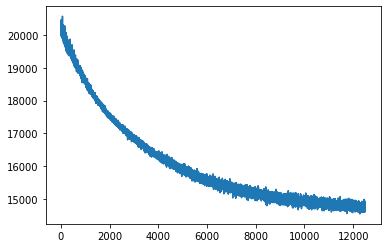

In [8]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp1["losses"])

In [9]:
az_bs_exp1 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp1["guide"], 
    res_bs_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-bs_complex_mlm_trial_level-exp1svi.nc"
)

Posterior predictive checks show how the model captures the discrete nature of the responses and the larger proportion of responses divisible by 10 than by 5. The overall match is not perfect.

<AxesSubplot:xlabel='yhat / yhat'>

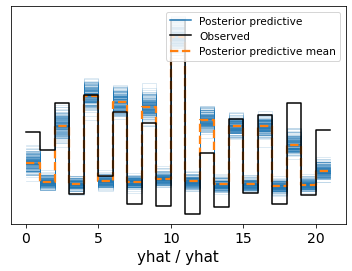

In [10]:
az.plot_ppc(az_bs_exp1, num_pp_samples=200)

The estimated `rnd_policy` variable shows a large proportion of "contaminant" responses (first value) and less rounding to 5 (second value) than 10 (last value). 

In [11]:
az_bs_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.43007357, 0.11345145, 0.45647498]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## Experiment 1: Bayesian Sampler with N varying trial-by-trial

Next I complete the same analyses for an extension of the Bayesian Sampler model that allows the effective number of samples drawn on each trial to vary trial-by-trial.

In [12]:
res_bs_exp1_varyN = fit_svi(
    bs_complex_mlm_trial_level_varyN, 
    X_exp1, 
    y_exp1,
    optimizer = ClippedAdam(1e-3, clip_norm=1., b1=.95), 
    loss = TraceGraph_ELBO(num_particles=2), 
    n_steps = 6_000, 
    full_rank = True,
    filename = "local/svi-bs_complex_mlm_trial_level-exp1-varyingN.p"
)

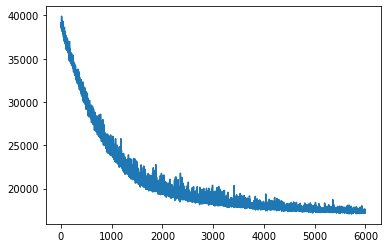

In [13]:
plt.plot(res_bs_exp1_varyN["losses"])

In [14]:
az_bs_exp1_varyN = arviz_from_svi(
    bs_complex_mlm_trial_level_varyN, 
    res_bs_exp1_varyN["guide"], 
    res_bs_exp1_varyN["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-bs_complex_mlm_trial_level-exp1svi-varyingN.nc"
)

In [15]:
az_bs_exp1_varyN.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.30127373, 0.18486306, 0.51386321]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## Experiment 1: Noise-based model

And finally I fit for the noise-based model.

In [16]:
res_ptn_exp1 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_exp1, 
    y_exp1,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-ptn_simplecond_mlm_trial_level_disc-exp1.p"
)

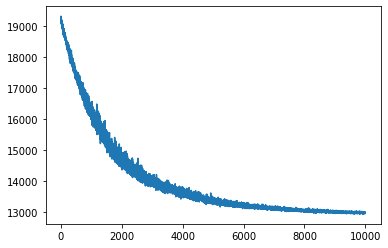

In [17]:
plt.plot(res_ptn_exp1["losses"])

In [18]:
az_ptn_exp1 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp1["guide"], 
    res_ptn_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp1svi.nc"
)

<AxesSubplot:xlabel='yhat / yhat'>

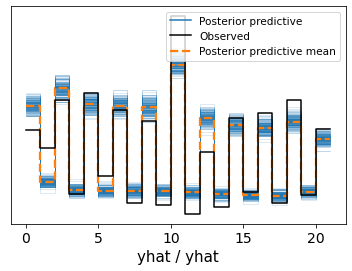

In [19]:
az.plot_ppc(az_ptn_exp1, num_pp_samples=200)

In [20]:
az_ptn_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.1131223 , 0.31577422, 0.57110348]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## Experiment 1: Model comparison

In [21]:
exp1_comparison = az.compare({"bs": az_bs_exp1, "bs-varying": az_bs_exp1_varyN, "ptn":az_ptn_exp1})

with open('paper-rmd/exp1-trial-level-comparison.csv', 'w') as tf:
     tf.write(exp1_comparison.to_csv())

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated sha

In [22]:
exp1_comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-12256.001947,437.854747,0.000000,0.914179,91.734328,0.000000,True,log
bs-varying,1,-14079.743742,1617.799396,1823.741795,0.069571,83.246341,74.533318,True,log
bs,2,-14866.731373,1384.545059,2610.729426,0.016250,74.859255,83.834564,True,log


## Experiment 2: Bayesian Sampler

In [13]:
res_bs_exp2 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    loss = TraceGraph_ELBO(num_particles=4),
    n_steps = 5_000,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp2.p"
)

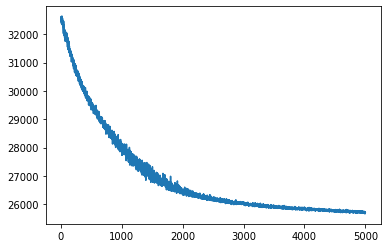

In [14]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp2["losses"])

In [15]:
az_bs_exp2 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp2["guide"], 
    res_bs_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-bs_complex_mlm_trial_level-exp2svi.nc"
)

<AxesSubplot:xlabel='yhat / yhat'>

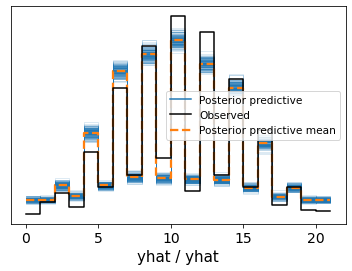

In [26]:
az.plot_ppc(az_bs_exp2, num_pp_samples=200)

In [27]:
az_bs_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.25902568, 0.19021369, 0.55076063]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

### Experiment 2: Bayesian sampler with N varying trial-by-trial 

In [ ]:
res_bs_exp2_varyN = fit_svi(
    bs_complex_mlm_trial_level_varyN, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(3.3e-4),
    loss = TraceGraph_ELBO(num_particles=2),
    n_steps = 12_500,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp2-varyingN.p"
)

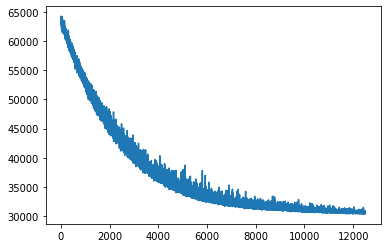

In [8]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp2_varyN["losses"])

In [9]:
az_bs_exp2_varyN = arviz_from_svi(
    bs_complex_mlm_trial_level_varyN, 
    res_bs_exp2_varyN["guide"], 
    res_bs_exp2_varyN["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-bs_complex_mlm_trial_level-exp2svi-varyingN.nc"
)

<AxesSubplot:xlabel='yhat / yhat'>

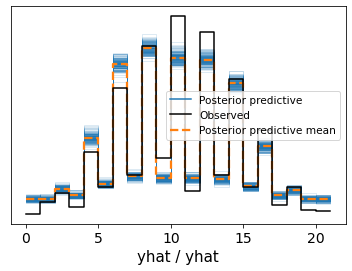

In [10]:
az.plot_ppc(az_bs_exp2_varyN, num_pp_samples=200)

In [16]:
az_bs_exp2_varyN.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.28003049, 0.1854264 , 0.5345431 ]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [33]:
az_bs_exp2_varyN.posterior.N_trial_sd.mean(axis=1)

<xarray.DataArray 'N_trial_sd' (chain: 1)>
array([0.55757277])
Coordinates:
  * chain    (chain) int64 0

The plot below shows the distribution of the $N_{trial}$ parameter, which multiplies $N$. Most values are near 1, but there is some range as well.

<AxesSubplot:>

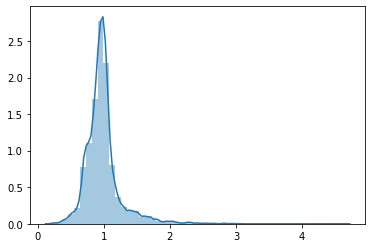

In [22]:
sns.distplot(np.exp(az_bs_exp2_varyN.posterior.N_trial.mean(axis=1).to_numpy()))

## Experiment 2: Noise-based model

In [17]:
res_ptn_exp2 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    n_steps = 6_000,
    full_rank = True,
    filename = "local/svi-ptn_simplecond_mlm_trial_level_disc-exp2.p"
)

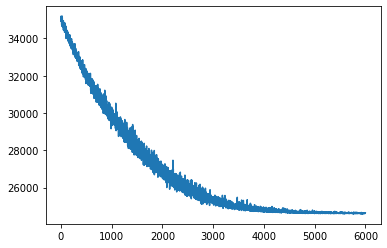

In [18]:
plt.plot(res_ptn_exp2["losses"])

In [19]:
az_ptn_exp2 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp2["guide"], 
    res_ptn_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp2svi.nc"
)

<AxesSubplot:xlabel='yhat / yhat'>

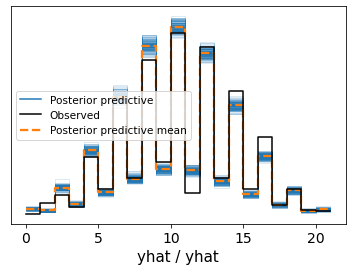

In [38]:
az.plot_ppc(az_ptn_exp2, num_pp_samples=200)

In [39]:
az_ptn_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.03839656, 0.37593138, 0.58567206]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [20]:
exp2_comparison = az.compare({"bs": az_bs_exp2, "bs-varying": az_bs_exp2_varyN, "ptn":az_ptn_exp2})

with open('paper-rmd/exp2-trial-level-comparison.csv', 'w') as tf:
     tf.write(exp2_comparison.to_csv())

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated sha

In [23]:
exp2_comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-24053.385109,573.977814,0.000000,0.936878,92.053342,0.000000,True,log
bs,1,-25376.016007,1177.320534,1322.630898,0.063122,100.908870,55.973116,True,log
bs-varying,2,-26027.463831,2154.557992,1974.078723,0.000000,94.154552,53.910005,True,log


Allowing N to vary trial-by-trial improves things for BS. Reduces % of contaminants and improves elpd_loo. But still doing substantially worse than noise-based model. 

# Supplemental plots: Noise-based model

### Exp 1: Population-level parameters

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

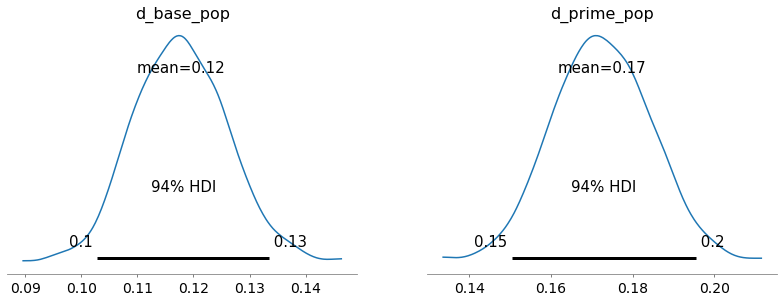

In [42]:
az_ptn_exp1.posterior["d_prime_pop"] = az_ptn_exp1.posterior.d_base_pop + np.exp(az_ptn_exp1.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp1, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

# az.plot_forest(data=az_ptn_exp1, var_names=["d_subj"], combined=True)

### Exp 2: Population-level parameters

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

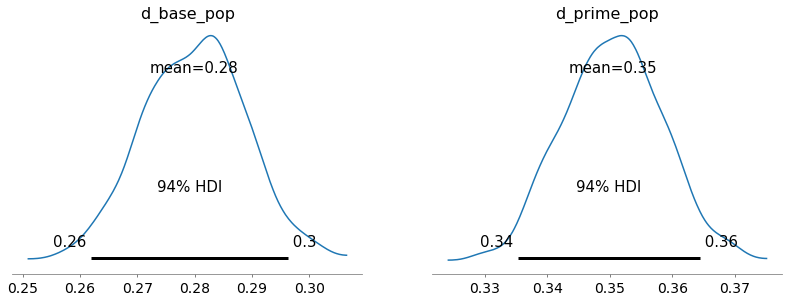

In [43]:
az_ptn_exp2.posterior["d_prime_pop"] = az_ptn_exp2.posterior.d_base_pop + np.exp(az_ptn_exp2.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp2, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

### Exp 1: Forest plots

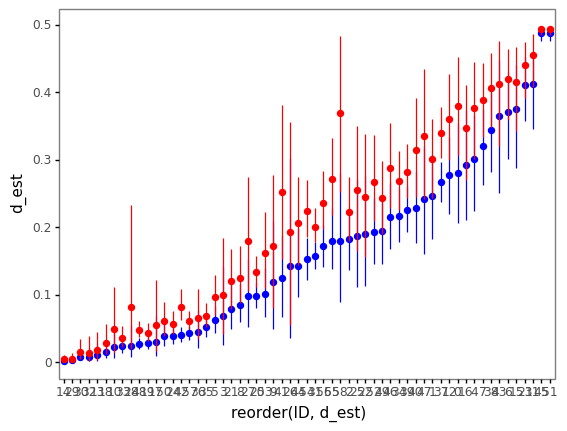

<ggplot: (2970121185179)>

In [46]:
posterior_ptn1 = posterior_to_df_mlm(
    az_ptn_exp1, 
    ["d_prime_pop","d_base_pop"],
    ["k","d_prime_subj", "d_subj"]
)

(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        dprime_est = _.d_prime_subj.mean(),
        dprime_ll = _.d_prime_subj.quantile(.05),
        dprime_ul = _.d_prime_subj.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    ggplot() +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="d_est", ymin="d_ll", ymax="d_ul"), color="blue") +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="dprime_est", ymin="dprime_ll", ymax="dprime_ul"), color="red") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

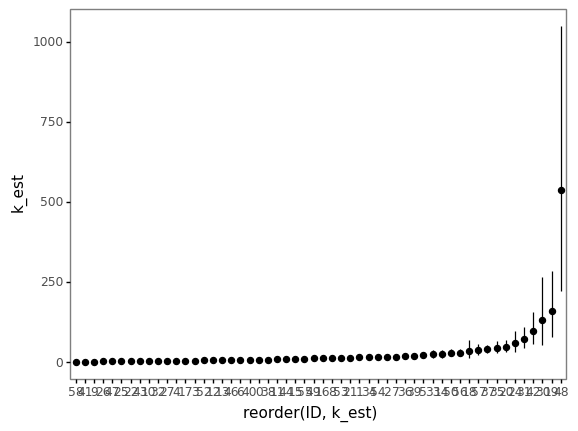

<ggplot: (2970121561341)>

In [47]:
(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    s.filter(_.ID!=51, _.ID!=45, _.ID!=23, _.ID!=28, _.ID!=29) >> ## problematic Ps
    ggplot(aes(x="reorder(ID, k_est)", y="k_est", ymin="k_ll", ymax="k_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

### Exp 2: Forest plots

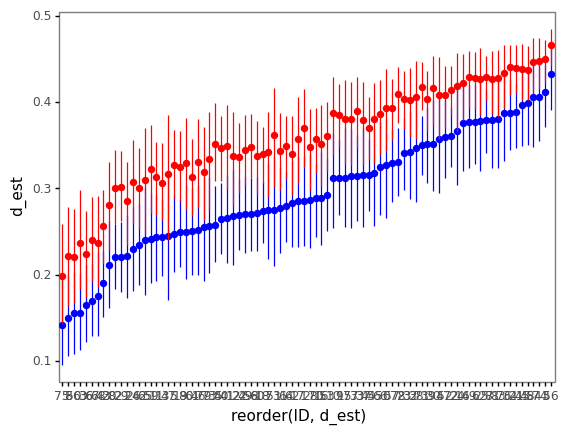

<ggplot: (2970078820756)>

In [48]:
posterior_ptn2 = posterior_to_df_mlm(
    az_ptn_exp2, 
    ["d_prime_pop","d_base_pop"],
    ["k","d_prime_subj", "d_subj"]
)

(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        dprime_est = _.d_prime_subj.mean(),
        dprime_ll = _.d_prime_subj.quantile(.05),
        dprime_ul = _.d_prime_subj.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    ggplot() +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="d_est", ymin="d_ll", ymax="d_ul"), color="blue") +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="dprime_est", ymin="dprime_ll", ymax="dprime_ul"), color="red") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

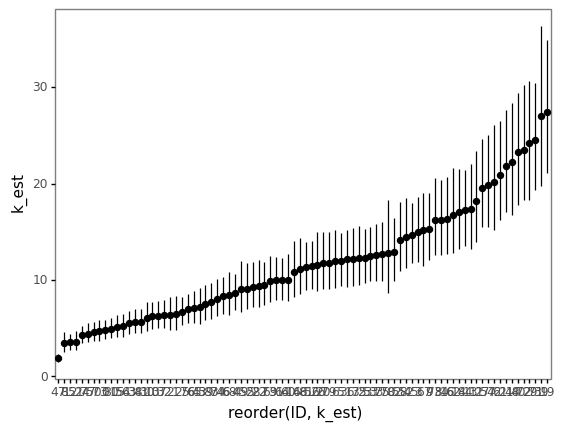

<ggplot: (-9223369066732576547)>

In [49]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
#     s.filter(_.k_est > 50) >>
#     s.filter(_.ID!=51, _.ID!=45, _.ID!=23, _.ID!=28, _.ID!=29) >>
    ggplot(aes(x="reorder(ID, k_est)", y="k_est", ymin="k_ll", ymax="k_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

# Supplemental plots BS model inspection

In [50]:
posterior_bs2 = posterior_to_df_mlm(
    az_bs_exp2, 
    ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "N_subj", "N_prime_subj", "beta_subj"]
)

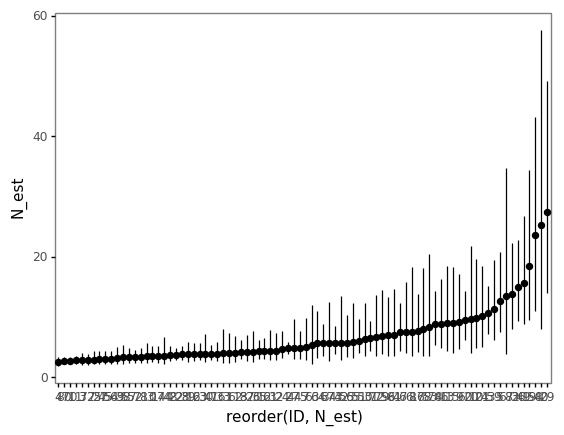

<ggplot: (-9223369066732278542)>

In [51]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

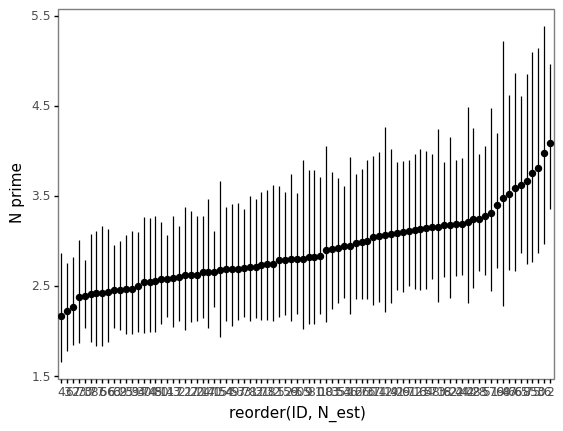

<ggplot: (-9223369066731987049)>

In [52]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
    labs(y="N prime") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

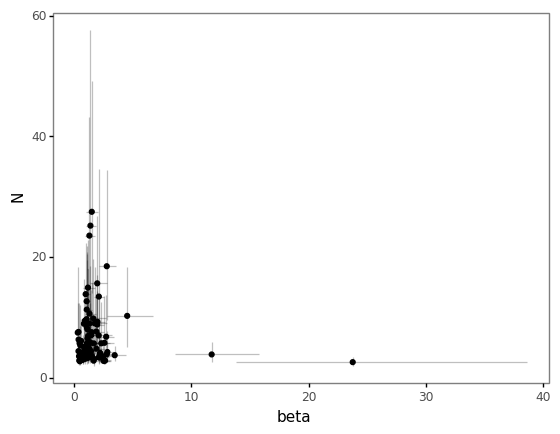

<ggplot: (2970123082956)>

In [53]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

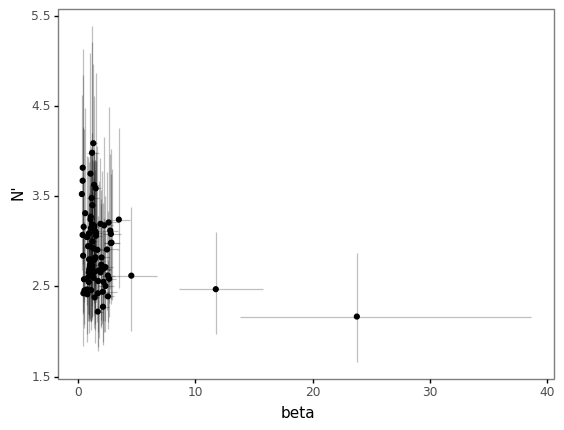

<ggplot: (-9223369066731706978)>

In [54]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N'", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

# Supplemental plots: Pairs plots

array([[<AxesSubplot:ylabel='d_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='d_base_sd'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='d_base_pop', ylabel='d_delta_sd'>,
        <AxesSubplot:xlabel='d_delta_pop'>,
        <AxesSubplot:xlabel='d_base_sd'>]], dtype=object)

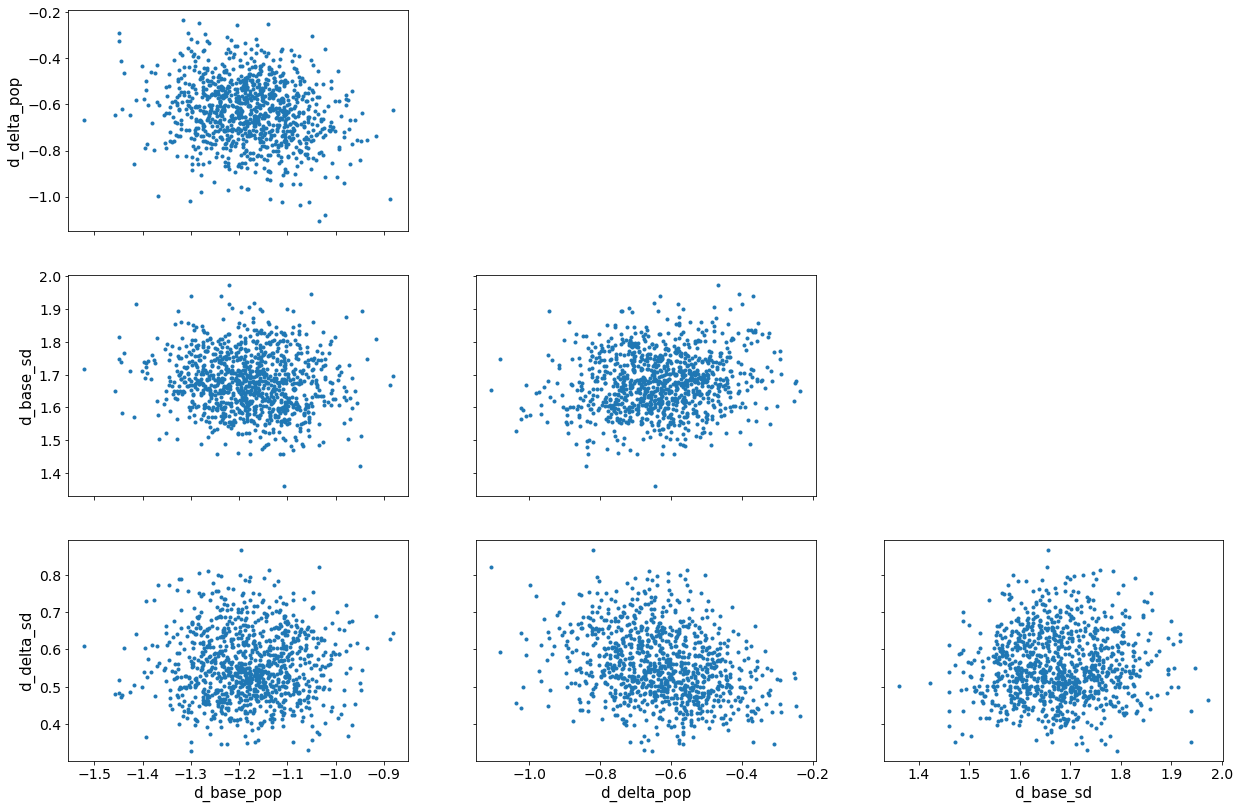

In [55]:
# posterior_ptn2b = dist_to_df(
#     az_ptn_exp2, 
#     ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"]
# )
# posterior_ptn2b
az.plot_pair(az_ptn_exp1, var_names = ["d_base_pop","d_delta_pop","d_base_sd", "d_delta_sd"])

array([[<AxesSubplot:ylabel='d_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='d_base_sd'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='d_base_pop', ylabel='d_delta_sd'>,
        <AxesSubplot:xlabel='d_delta_pop'>,
        <AxesSubplot:xlabel='d_base_sd'>]], dtype=object)

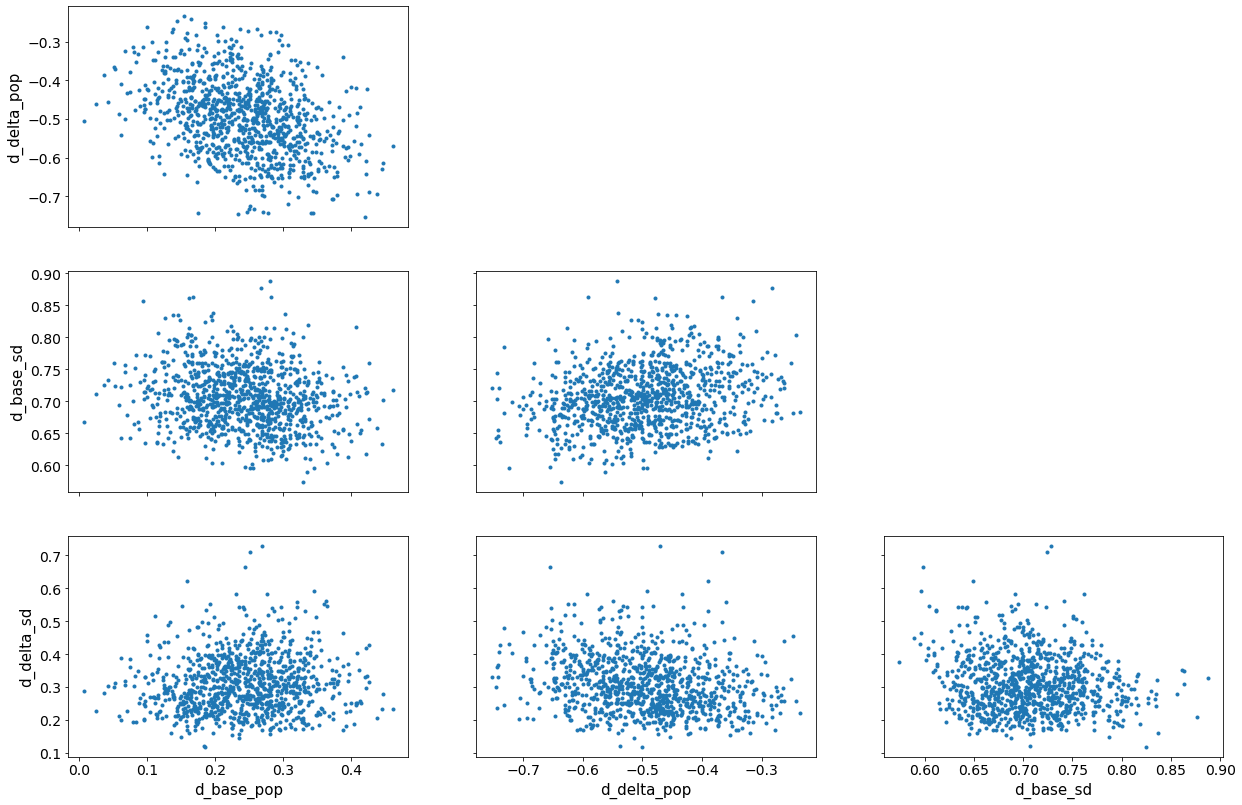

In [56]:
az.plot_pair(az_ptn_exp2, var_names = ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"])

array([[<AxesSubplot:ylabel='N_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='N_prime_sd'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='N_prime_pop', ylabel='N_delta_sd'>,
        <AxesSubplot:xlabel='N_delta_pop'>,
        <AxesSubplot:xlabel='N_prime_sd'>]], dtype=object)

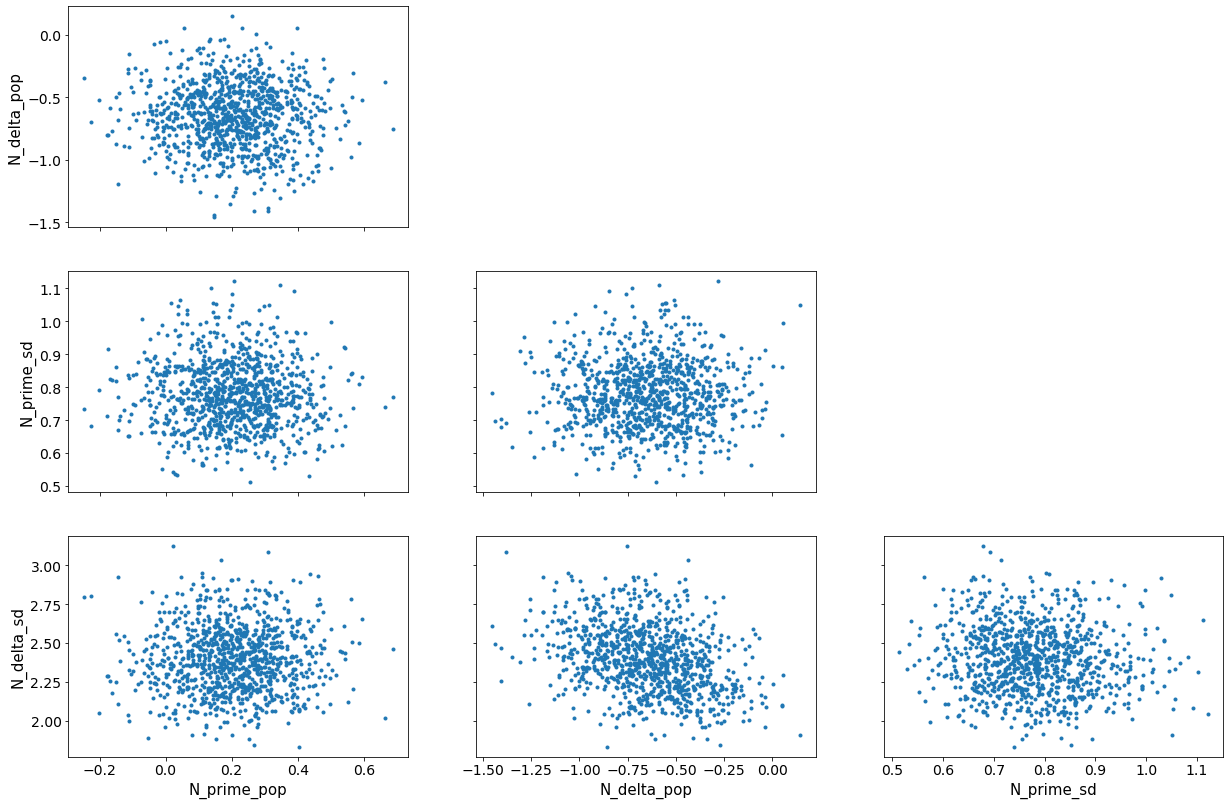

In [57]:
az.plot_pair(az_bs_exp1, var_names = ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd"])

array([[<AxesSubplot:ylabel='N_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='N_prime_sd'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='N_prime_pop', ylabel='N_delta_sd'>,
        <AxesSubplot:xlabel='N_delta_pop'>,
        <AxesSubplot:xlabel='N_prime_sd'>]], dtype=object)

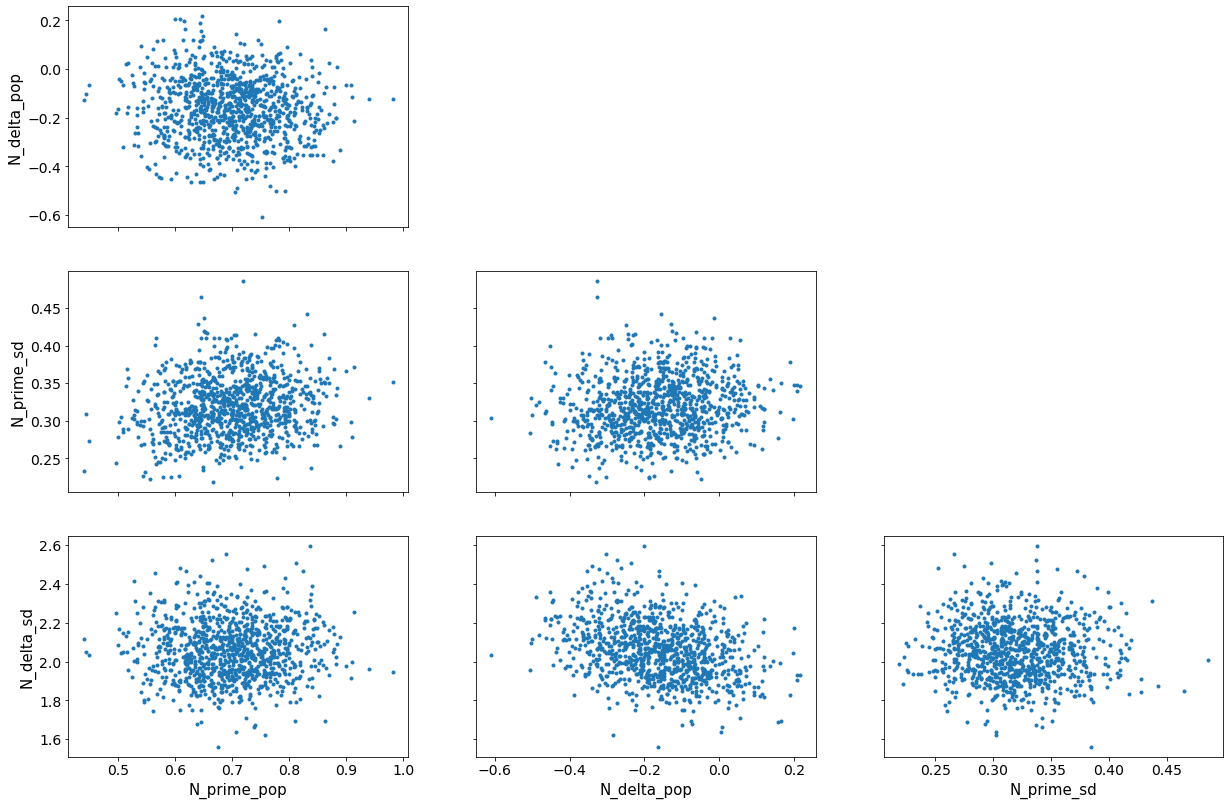

In [58]:
az.plot_pair(az_bs_exp2, var_names = ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd"])